In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.abspath(current_dir)))
from Grover.grover_num_list_cirq import find_num, find_num_list
from Backend.fake_backend import FakeBackend
from Backend.backend import Backend
from Backend.ibm_backend import IBM_backend

from Result.result import ResultData

from qiskit.visualization import plot_histogram, plot_coupling_map
from backend_operation import run_simulator, get_transpiled_circuits_of_circuit, get_fake_backend_list,get_unitary, get_fake_backend, get_fake_backend_list
from qiskit import transpile
import qiskit.providers.fake_provider
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.passes import RemoveBarriers
from qiskit_aer import AerSimulator, Aer

from itertools import permutations

from save_data_to_file import CSVWriter

Number of Grover circuits : 1


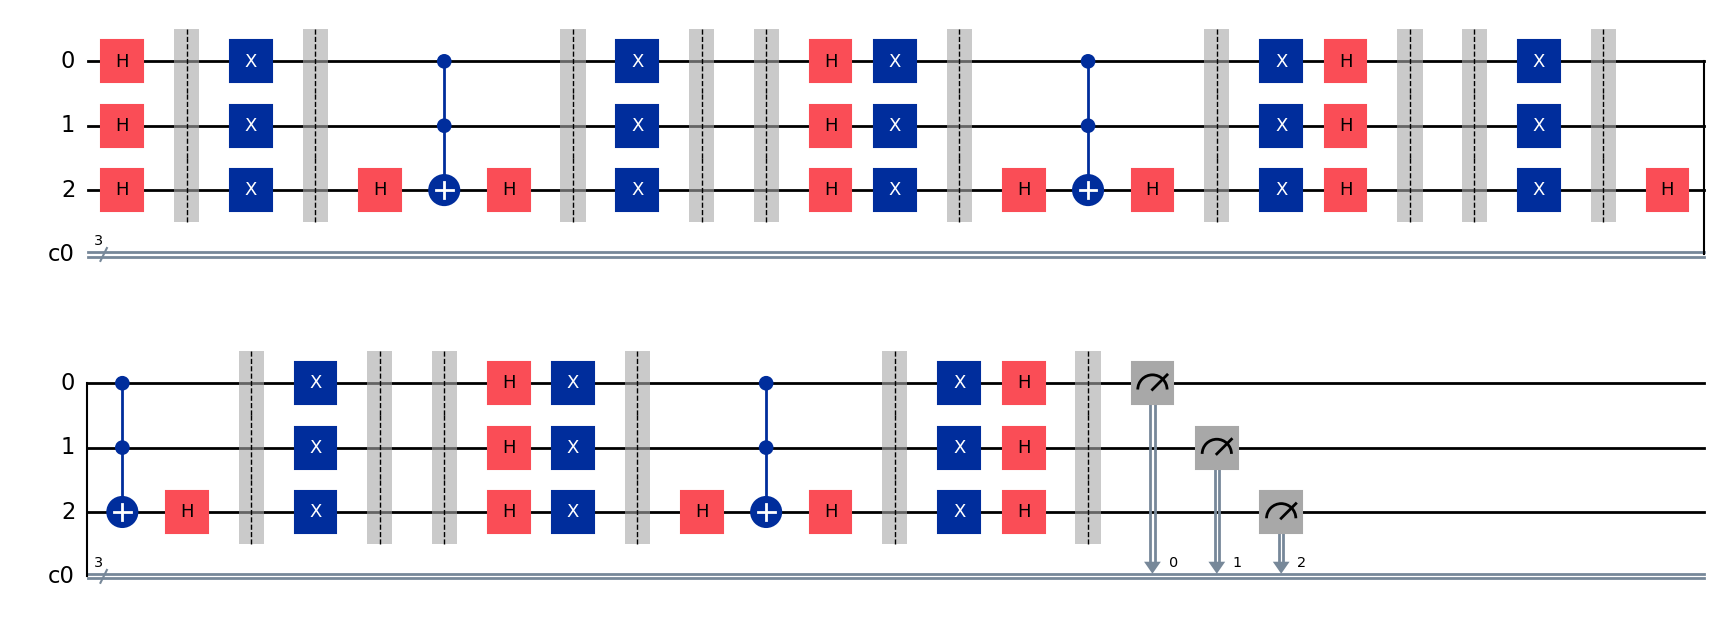

In [2]:
# Sample of Find Number Grover Circuit
find_num_in_world_obj =  find_num()
find_num_in_world_obj.build_iteration(winner_num_list=[0], circuit_nqubits=3, block_diagram=False)
find_num_in_world_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_world_obj.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
cur_experiments[0].draw('mpl')

In [3]:
cur_experiments[0].depth()

26

In [4]:
backend = Backend(num_qubits=3)
# backend.get_backend_coupling_map()

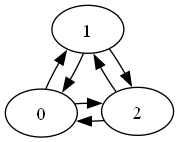

In [9]:
backend = qiskit.providers.fake_provider.GenericBackendV2(num_qubits=3)
backend.coupling_map.draw()

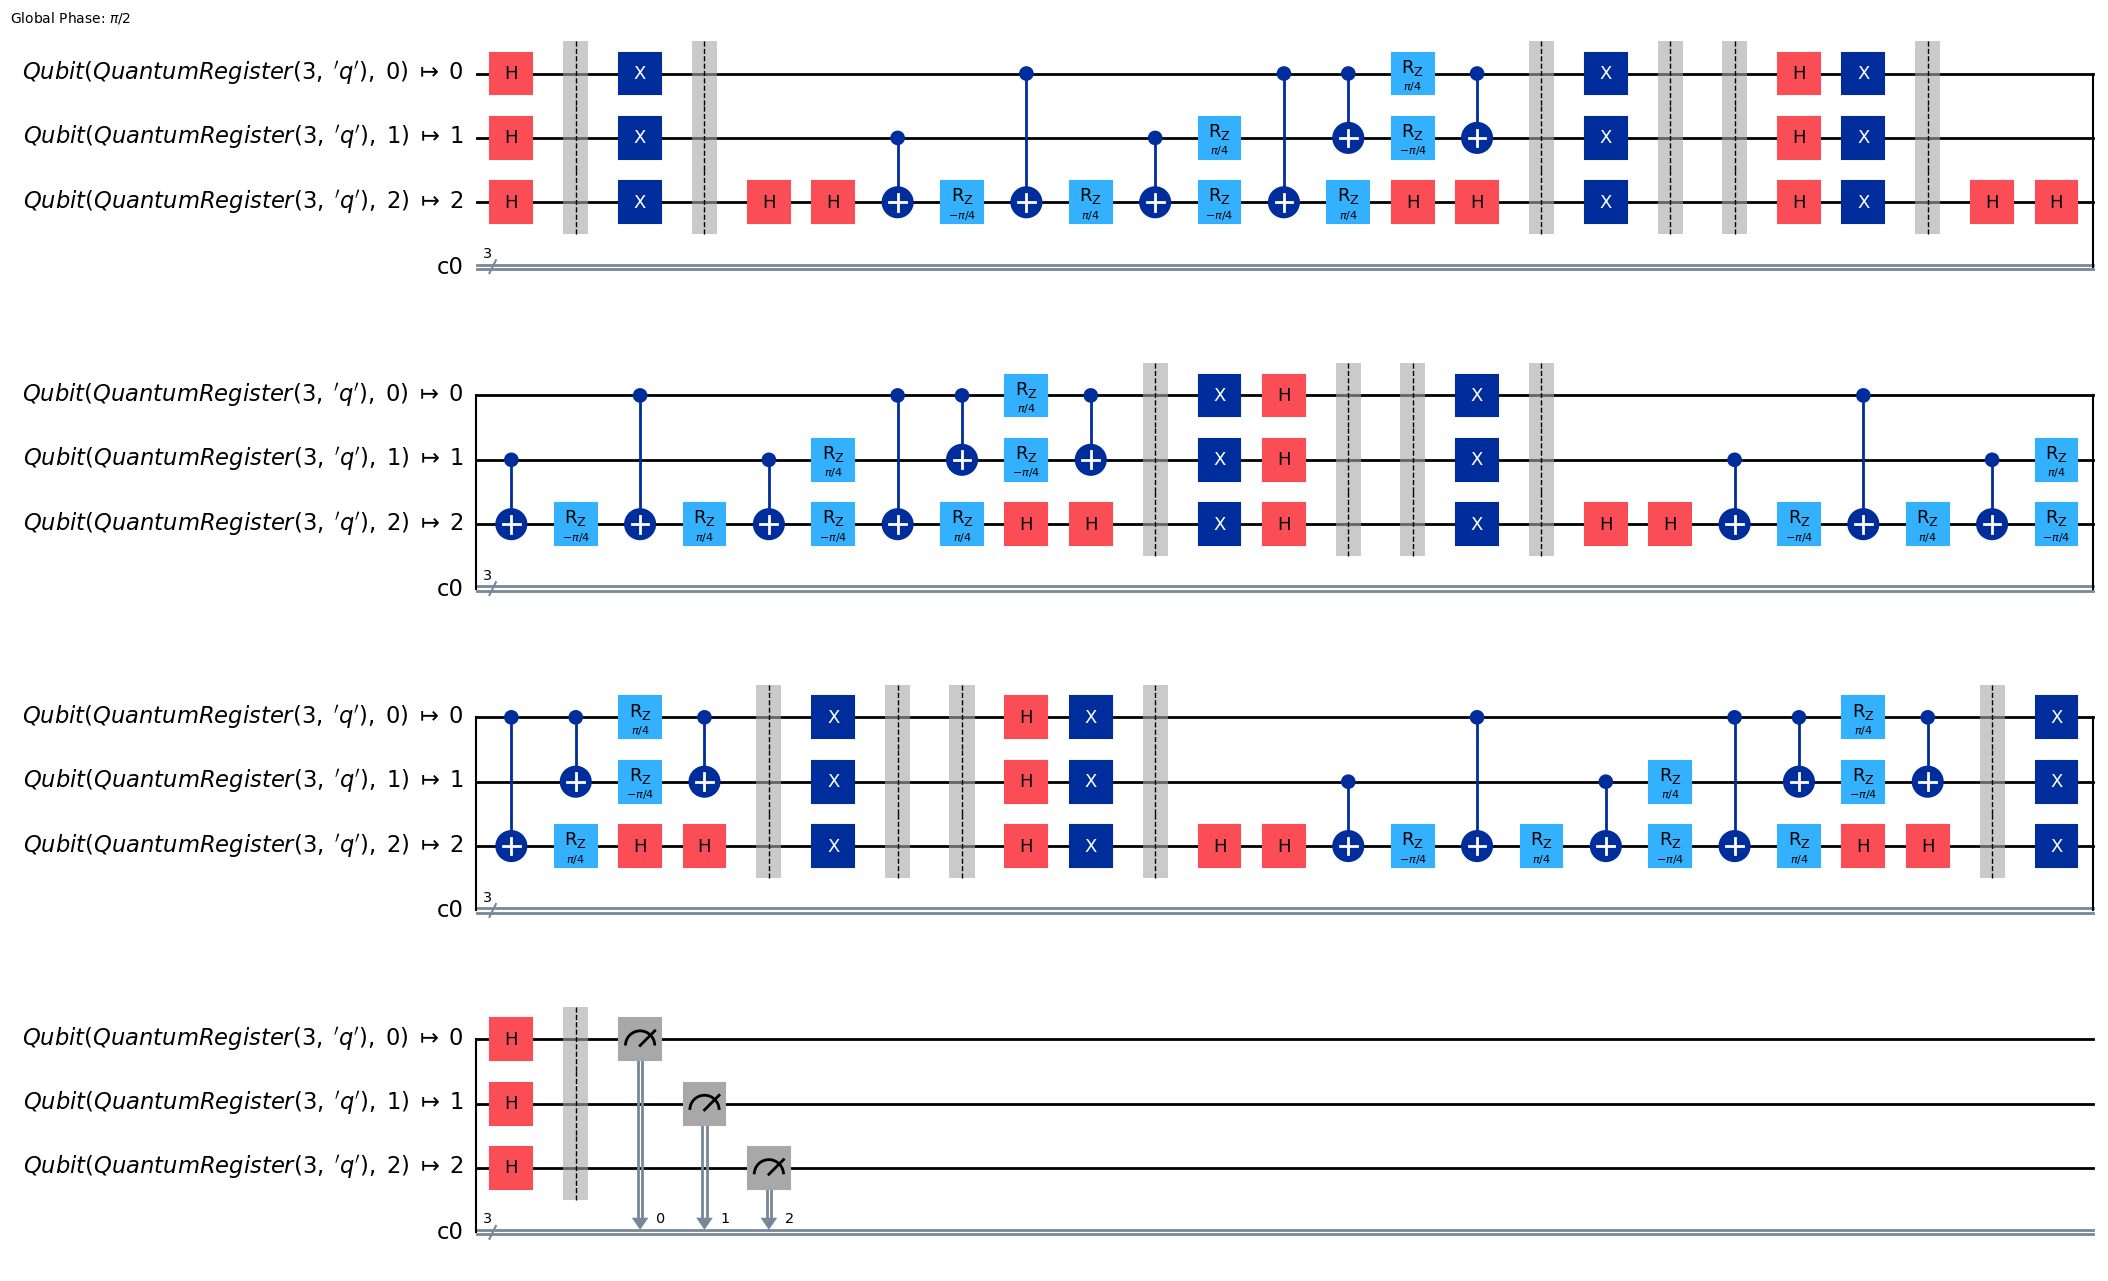

In [5]:
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(cur_experiments[0], backend.get_backend(), optimization_level=0)
transpiled_circuit.draw('mpl')


In [6]:
transpiled_circuit.depth()

62

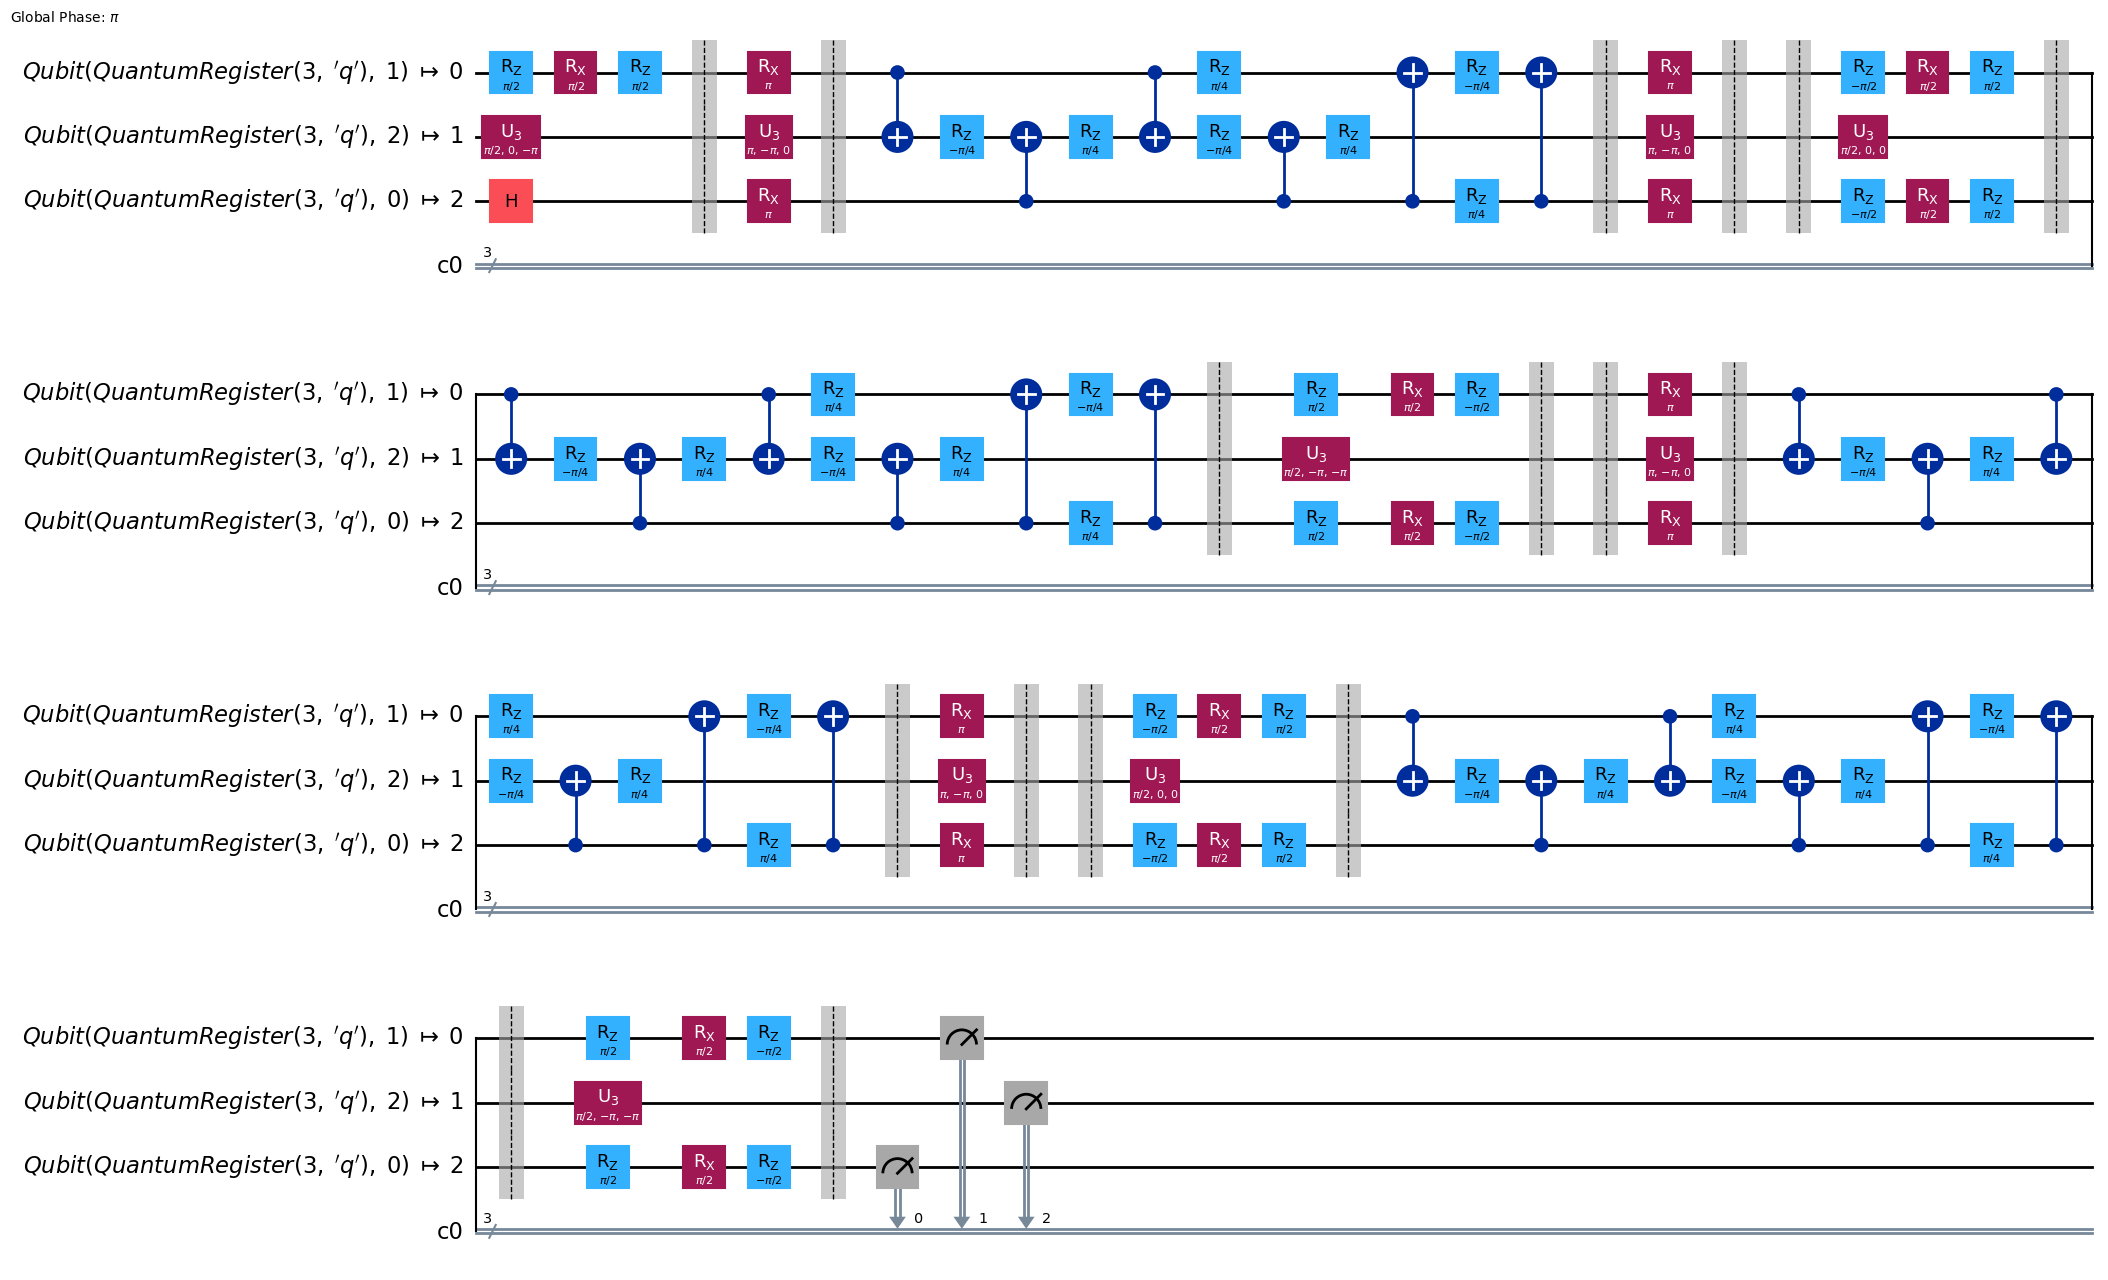

In [7]:
transpiled_circuit = transpile(cur_experiments[0], backend.get_backend(), optimization_level=3)
transpiled_circuit.draw('mpl')

In [8]:
transpiled_circuit.depth()

60

In [2]:
find_num_obj = find_num()
num_qubits = 3
qc_find_num_list = []
seed = 42

for value in range(2**num_qubits):
    find_num_obj.build_iteration(winner_num_list=[value], circuit_nqubits=num_qubits, block_diagram=False)
    find_num_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    qc_find_num_list.append(find_num_obj.measure_qc[0])

In [3]:
generic_backend = Backend(num_qubits)
backend_names = FakeBackend.get_ibm_fake_backend_names_with_limit(num_qubits)
fake_auckland_backend = FakeBackend.get_ibm_fake_backend('fake_auckland')
print(f"Fake Auckland number of qubits = {fake_auckland_backend.num_qubits}")

Fake Auckland number of qubits = 27


In [4]:
fake_backend_name = 'fake_auckland'
fake_backend = FakeBackend(fake_backend_name)

In [5]:
position_layout = list(permutations(range(fake_backend.get_backend_qubits()), num_qubits))

In [6]:
position_layout = list(permutations(range(num_qubits), num_qubits))

In [7]:
qc_find_num_list_without_barriar = [RemoveBarriers()(qc) for qc in qc_find_num_list]

In [8]:
# Add the Generic Aer Full Connectivity
qc_transpiled_list = [
    generic_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
qc_transpiled_list = qc_transpiled_list + [
    generic_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
position_layout = list(position_layout)
# Add the fake backend
for layout in [None] + position_layout:
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]

In [9]:
print(qc_transpiled_list)

[<Backend.backend.saved_transpile_action_parameters object at 0x000001E6A79142D0>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A86015D0>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A7913E90>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A75EDF50>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A72932D0>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A8A0ED50>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A8601F50>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A8AB9390>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A8AF5990>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A8AEC610>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E5CDB5DBD0>, <Backend.backend.saved_transpile_action_parameters object at 0x000001E6A723A490>, <Backend.backen

In [10]:
len(qc_transpiled_list)

128

In [11]:
# Sample that we entered an input value to the result parameters to save
qc_transpiled_list[60].backend_name

'fake_auckland'

In [12]:
qc_res  = [
    qc_param.backend.run(qc_param.transpiled_qc,shots=4096)
    for qc_param in qc_transpiled_list
]

In [13]:
qc_res_seed  = [
    qc_param.backend.run(qc_param.transpiled_qc,shots=4096, seed_simulator=seed)
    for qc_param in qc_transpiled_list
]

In [14]:
len(qc_res)

128

In [15]:
qc_resultData = [ResultData(res) for res in qc_res]

In [ ]:
qc_resultData_seed = [ResultData(res) for res in qc_res_seed]
x = [res.set_seed(seed) for res in qc_resultData_seed]

In [ ]:
len(qc_resultData)

128

In [27]:
# excel_path = "../logs"
excel_name = "grover_results.csv"

save = CSVWriter(file_name=excel_name)

data = []
for qc_transpile, res_data, res_data_seed in zip(qc_transpiled_list, qc_resultData, qc_resultData_seed):
    data.append([qc_transpile, res_data])  
    data.append([qc_transpile, res_data_seed])  

save.save_data(data)

Data saved to ../logs\grover_results_2024_07_20_20_09_10.csv
